In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import math
import itertools
from PIL import Image
from glob import glob
from tqdm import tqdm_notebook, tnrange
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_dir = r'C:\Users\Dell\Downloads\instant training\brain_tumor_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

filepaths labels
0    C:\Users\Dell\Downloads\instant training\brain...     no
1    C:\Users\Dell\Downloads\instant training\brain...     no
2    C:\Users\Dell\Downloads\instant training\brain...     no
3    C:\Users\Dell\Downloads\instant training\brain...     no
4    C:\Users\Dell\Downloads\instant training\brain...     no
..                                                 ...    ...
248  C:\Users\Dell\Downloads\instant training\brain...    yes
249  C:\Users\Dell\Downloads\instant training\brain...    yes
250  C:\Users\Dell\Downloads\instant training\brain...    yes
251  C:\Users\Dell\Downloads\instant training\brain...    yes
252  C:\Users\Dell\Downloads\instant training\brain...    yes

[253 rows x 2 columns]

In [4]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

In [5]:
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='binary',   # 👈 binary
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='binary',   # 👈 binary
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


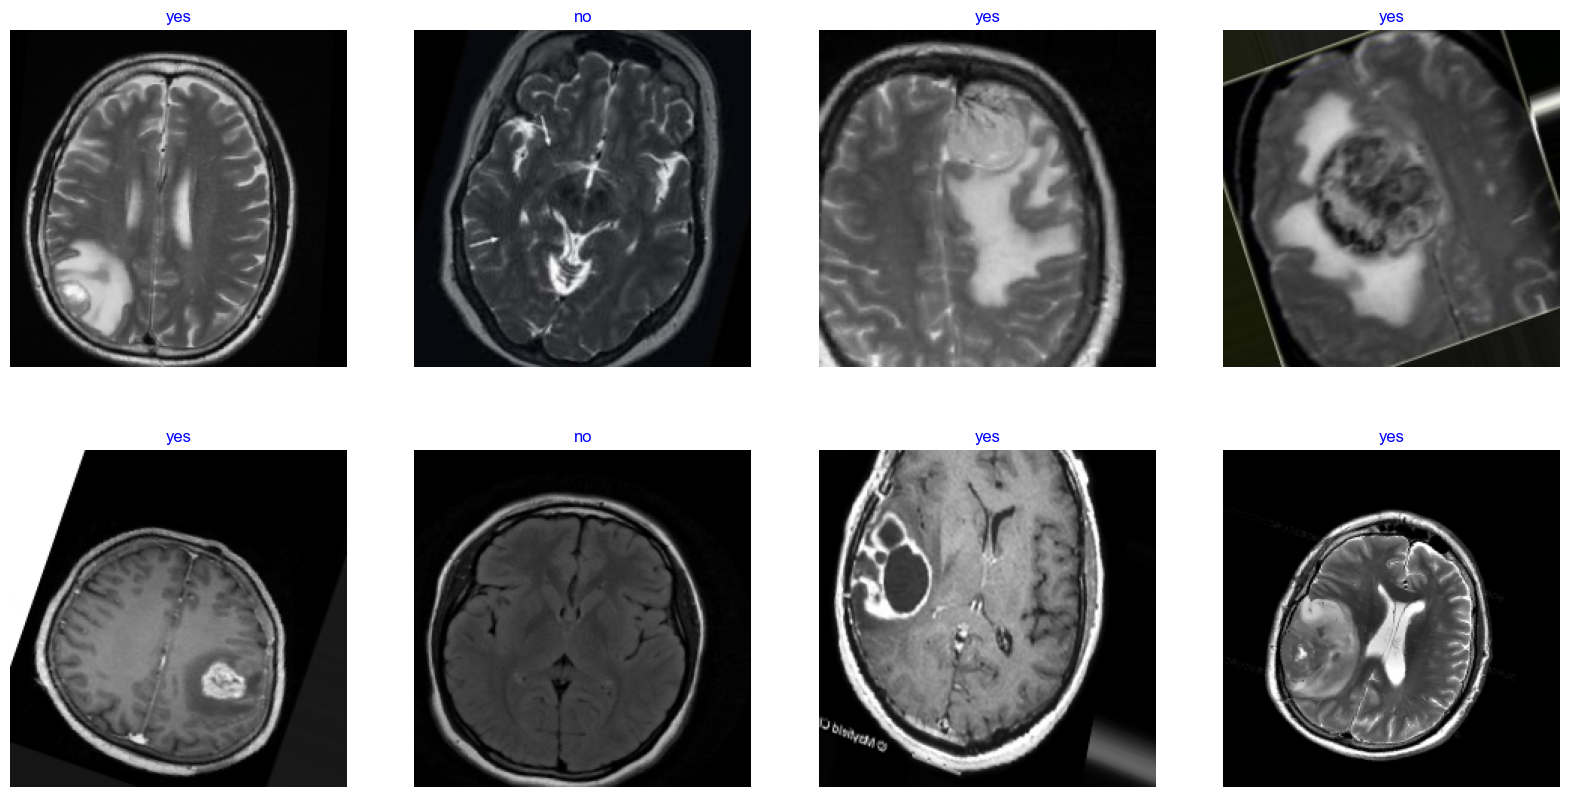

In [7]:
# Get class indices (0 -> no tumor, 1 -> tumor)
g_dict = train_gen.class_indices
classes = list(g_dict.keys())  # ['no', 'yes'] or similar

# Get one batch of images and labels
images, labels = next(train_gen)

plt.figure(figsize=(20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i]   # already scaled by generator (0-1)
    plt.imshow(image)
    
    # Label is now scalar 0 or 1
    index = int(labels[i])  
    class_name = classes[index]
    
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()


In [8]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling="max"
)

base_model.trainable = False  # freeze for transfer learning

model_inception = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")   # 👈 binary output
])

model_inception.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="binary_crossentropy",      # 👈 match with sigmoid
    metrics=["accuracy"]
)

model_inception.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,335,777 (85.20 MB)

 Trainable params: 528,897 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=1e-6
)

callbacks = [early_stop, lr_reduction]

In [10]:

history = model_inception.fit(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - accuracy: 0.6129 - loss: 1.0477 - val_accuracy: 0.7255 - val_loss: 0.8150 - learning_rate: 0.0010
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.7827 - loss: 0.5242 - val_accuracy: 0.7843 - val_loss: 0.4589 - learning_rate: 0.0010
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.8193 - loss: 0.4203 - val_accuracy: 0.8431 - val_loss: 0.5025 - learning_rate: 0.0010
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - accuracy: 0.8667 - loss: 0.5044 - val_accuracy: 0.8431 - val_loss: 0.4287 - learning_rate: 0.0010
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.8871 - loss: 0.2964 - val_accuracy: 0.8431 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.8630 - loss: 0.3063 - val_accuracy: 0.8431 - val_loss: 0.4437 - learning_rate: 0.0010
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.9115 - loss: 0.2243 -

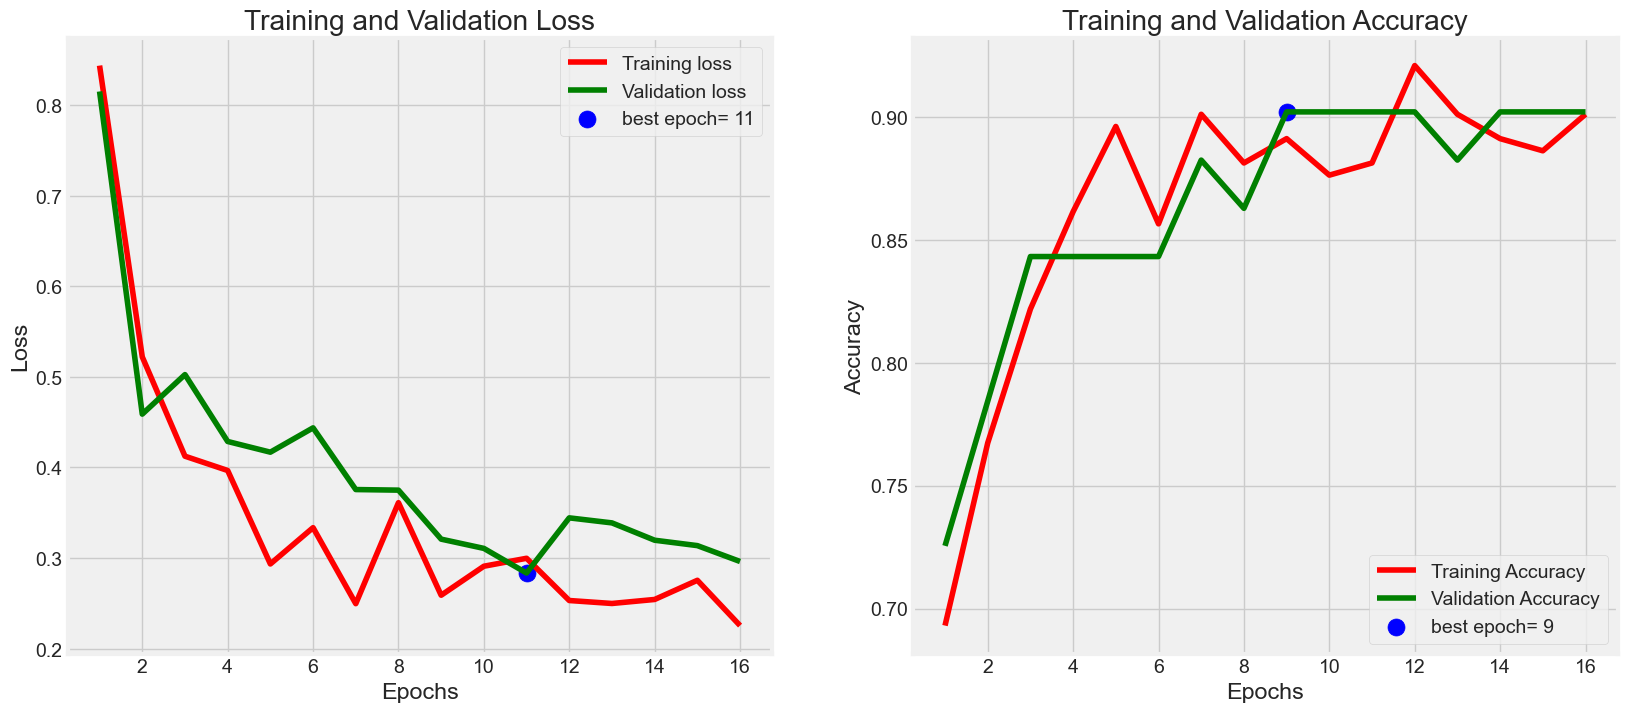

In [11]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
train_score = model_inception.evaluate(train_gen, verbose= 1)
test_score = model_inception.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9522 - loss: 0.0929
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9271 - loss: 0.2670
Train Loss:  0.0893385261297226
Train Accuracy:  0.9653465151786804
--------------------
Test Loss:  0.28345543146133423
Test Accuracy:  0.9019607901573181


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = test_gen.classes
y_pred = (model_inception.predict(test_gen) > 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=["no_tumor", "tumor"]))
print(confusion_matrix(y_true, y_pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step
              precision    recall  f1-score   support

    no_tumor       0.86      0.90      0.88        20
       tumor       0.93      0.90      0.92        31

    accuracy                           0.90        51
   macro avg       0.90      0.90      0.90        51
weighted avg       0.90      0.90      0.90        51

[[18  2]
 [ 3 28]]


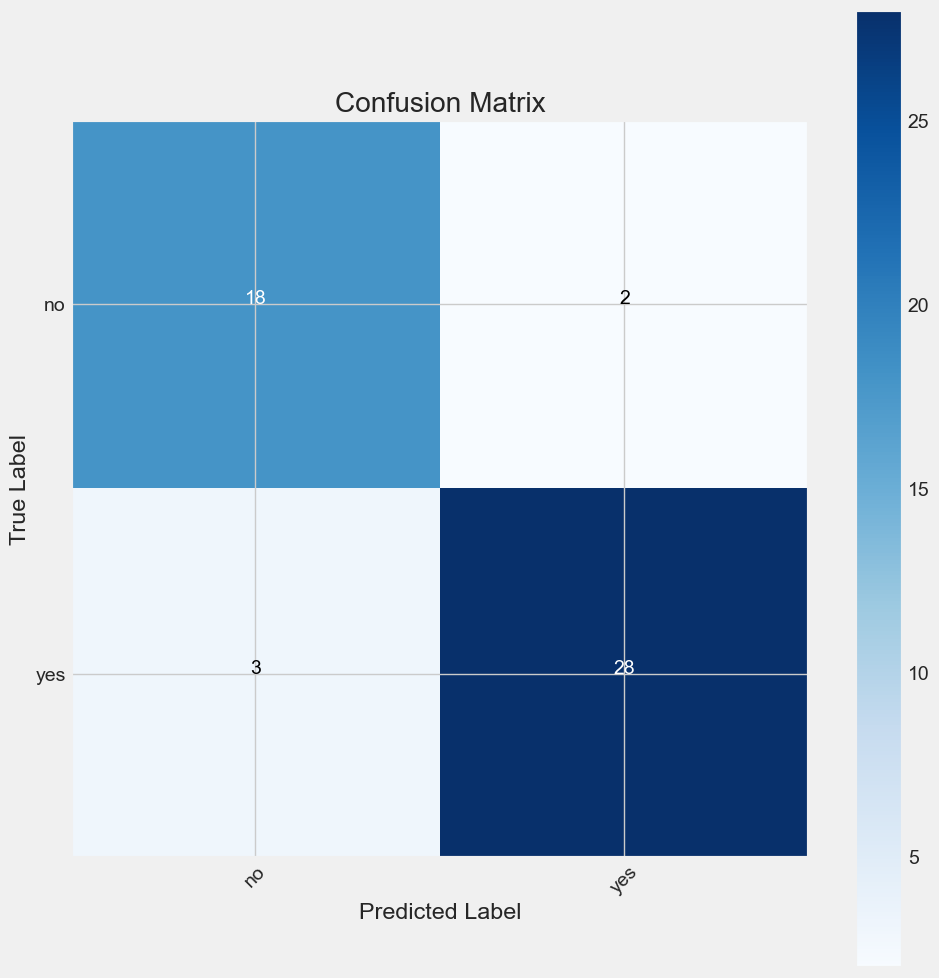

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
model_inception.save('brain_tumor_inception.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


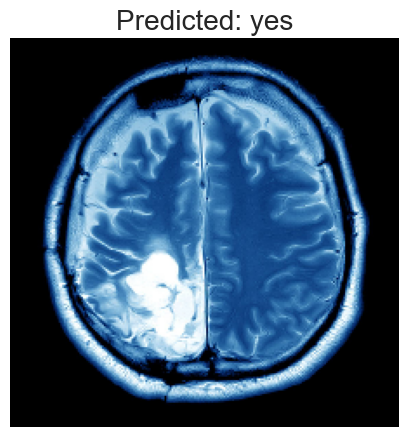

Predicted class: yes
Raw prediction probabilities: [[0.20216706 0.79783297]]


In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# path to your image
img_path = r"C:\Users\Dell\Downloads\brainImage.jpg"   # change this

# load and preprocess
img = image.load_img(img_path, target_size=(224, 224))  # resize same as training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # make batch of 1
img_array = img_array / 255.0  # normalize if your generators did rescale

# prediction
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]
class_labels = list(train_gen.class_indices.keys())

# show result
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {class_labels[pred_class]}")
plt.show()

print("Predicted class:", class_labels[pred_class])
print("Raw prediction probabilities:", pred)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, Activation
from tensorflow.keras.layers import UpSampling2D, concatenate, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Optional: enable mixed precision if you have a compatible GPU (speeds up + reduces mem)
# Uncomment if you have a GPU and CUDA/cuDNN installed:
# mixed_precision.set_global_policy('mixed_float16')


In [13]:
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    train_df, dummy_df = train_test_split(df, train_size= 0.8)
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [14]:
def create_gens(df, aug_dict):
    img_size = (128, 128)
    batch_size = 32

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

In [15]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        img_path = images[i]
        mask_path = masks[i]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))   # ✅ resize for consistency

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (128, 128))

        plt.imshow(image)
        plt.imshow(mask, alpha=0.4, cmap="Reds")  # ✅ better mask overlay
        plt.axis('off')

    plt.tight_layout()
    plt.show()


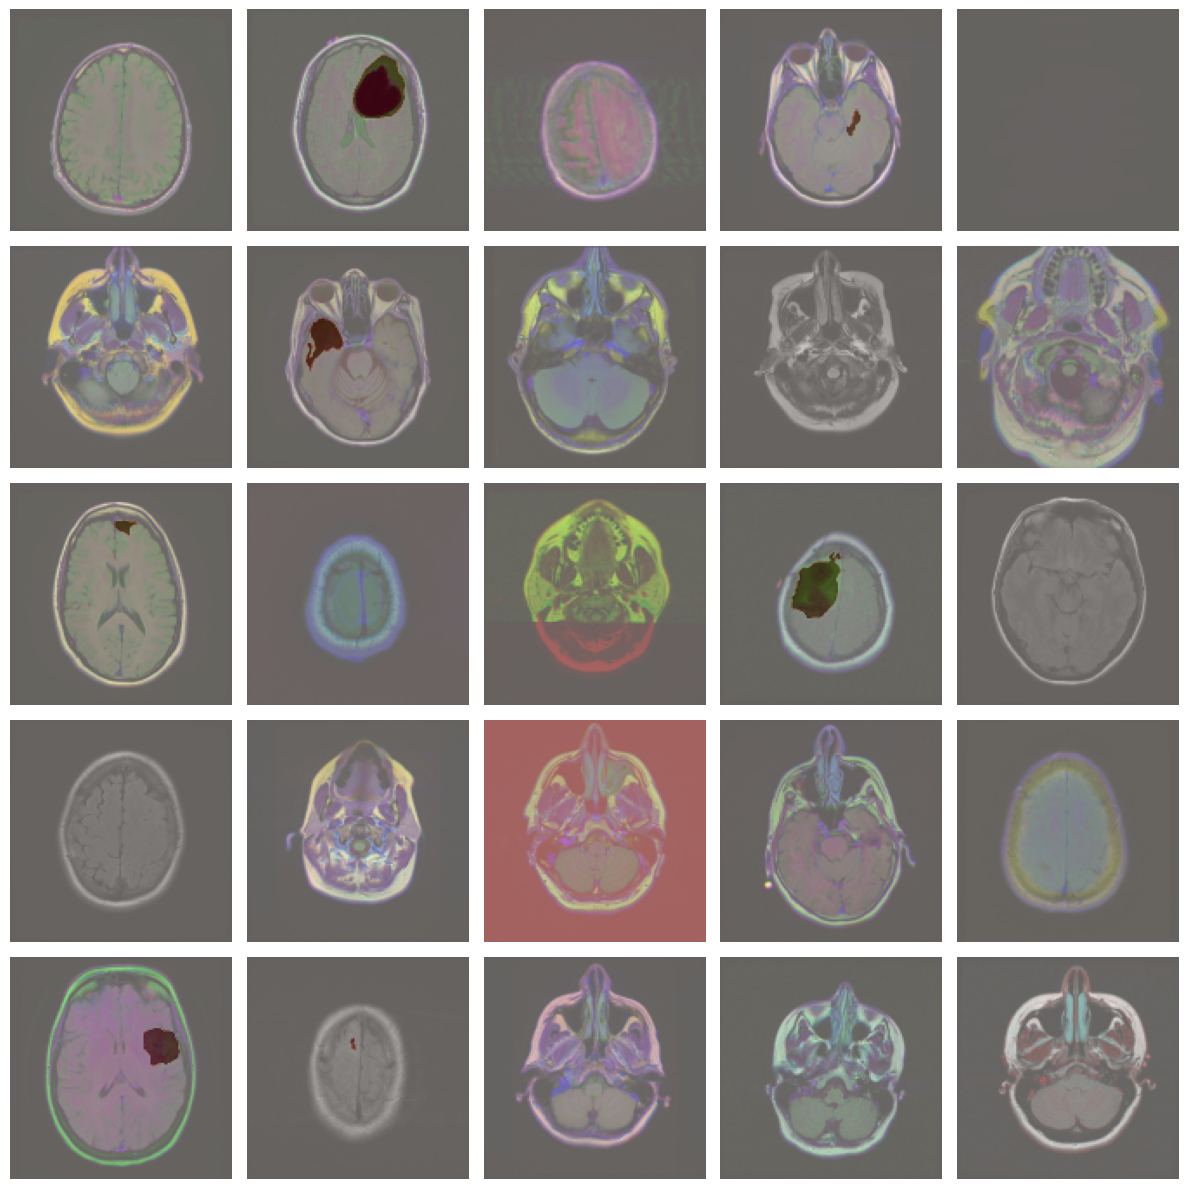

In [16]:
data_dir = r"C:\Users\Dell\Downloads\instant training\lgg-mri-segmentation\kaggle_3m"

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)


tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))



In [31]:
import tensorflow as tf
import keras.backend as K

# IoU metric
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # threshold
    y_true = tf.cast(y_true, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Dice metric
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [21]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Activation, concatenate, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf


def conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def decoder_block(input_tensor, skip_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = concatenate([x, skip_tensor])
    x = conv_block(x, num_filters)
    return x


def build_mobile_unet(input_shape=(128, 128, 3)):
    # Encoder (MobileNetV2 backbone)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape, include_top=False, weights="imagenet"
    )

    # Extract layers for skip connections
    skip1 = base_model.get_layer("block_1_expand_relu").output   # 64x64
    skip2 = base_model.get_layer("block_3_expand_relu").output   # 32x32
    skip3 = base_model.get_layer("block_6_expand_relu").output   # 16x16
    skip4 = base_model.get_layer("block_13_expand_relu").output  # 8x8

    encoder_output = base_model.get_layer("block_16_project").output  # 4x4

    # Decoder
    x = decoder_block(encoder_output, skip4, 512)  # 8x8
    x = decoder_block(x, skip3, 256)               # 16x16
    x = decoder_block(x, skip2, 128)               # 32x32
    x = decoder_block(x, skip1, 64)                # 64x64

    # Final conv (still 64x64)
    x = Conv2D(32, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Output layer (binary segmentation)
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(x)

    # 🔧 Extra upsampling to get 128x128
    outputs = UpSampling2D(size=(2, 2), interpolation="bilinear")(outputs)

    model = Model(inputs=base_model.input, outputs=outputs, name="MobileUNet")
    return model


In [22]:
# recommended small input to save memory; choose 128 or 160 if GPU/RAM limited
model = build_mobile_unet(input_shape=(128,128,3))
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "MobileUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 9,661,057 (36.85 MB)

 Trainable params: 9,628,161 (36.73 MB)

 Non-trainable params: 32,896 (128.50 KB)

In [23]:
# assume you already have train_gen and test_gen from ImageDataGenerator

history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_steps=20)



Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9377 - loss: 0.3078Found 393 validated image filenames.
Found 393 validated image filenames.
100/100 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9381 - loss: 0.3066 - val_accuracy: 0.9875 - val_loss: 0.0969
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9958 - loss: 0.0563 - val_accuracy: 0.9905 - val_loss: 0.0713
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9967 - loss: 0.0310 - val_accuracy: 0.9903 - val_loss: 0.0541
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - accuracy: 0.9970 - loss: 0.0209 - val_accuracy: 0.9902 - val_loss: 0.0479
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9972 - loss: 0.0158 - val_accuracy: 0.9919 - val_loss: 0.0404
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9973 - loss: 0.0129 - val_accuracy: 0.9930 - val_loss: 0.0311
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9974 - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


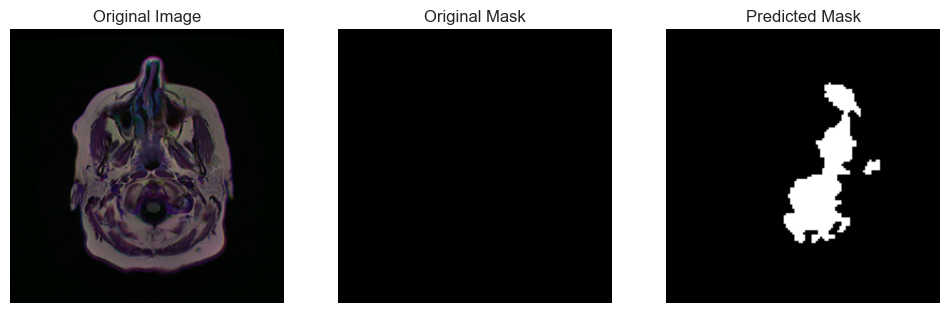

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


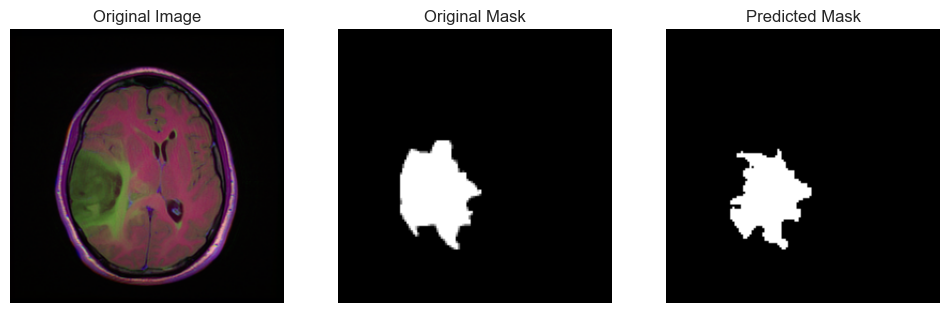

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


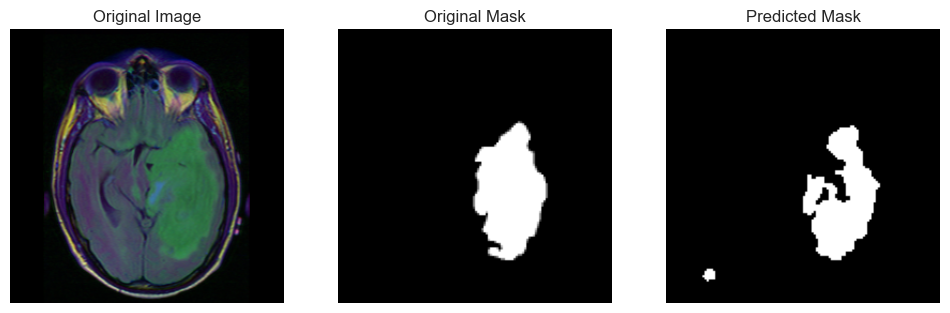

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


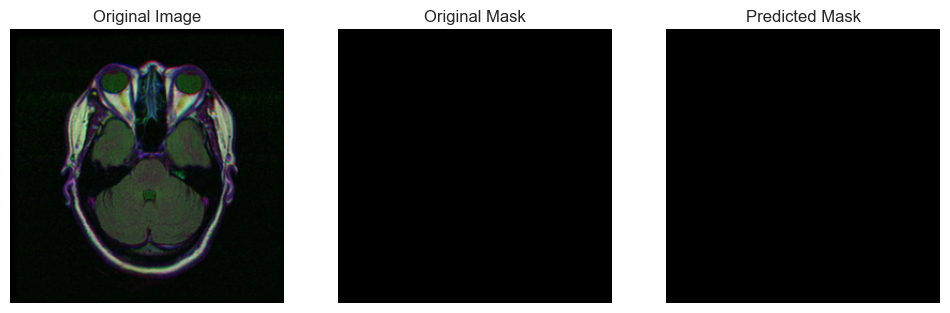

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


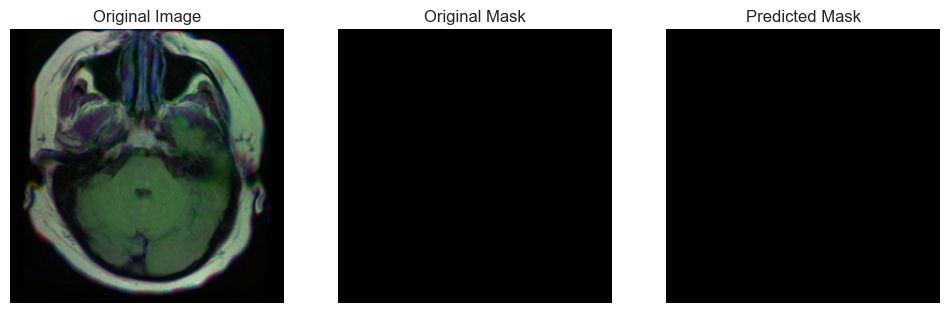

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


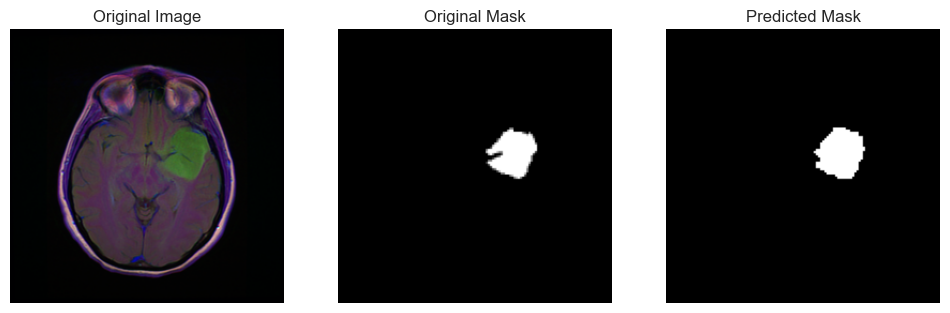

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


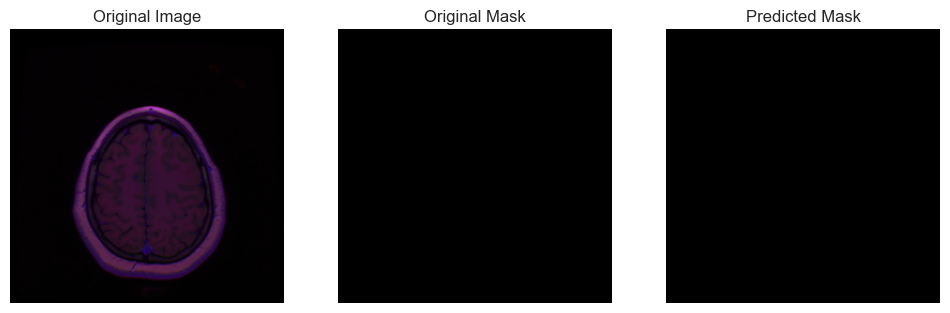

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


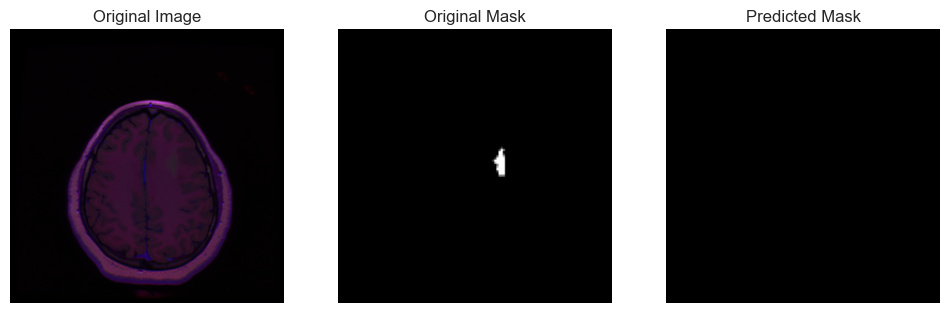

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


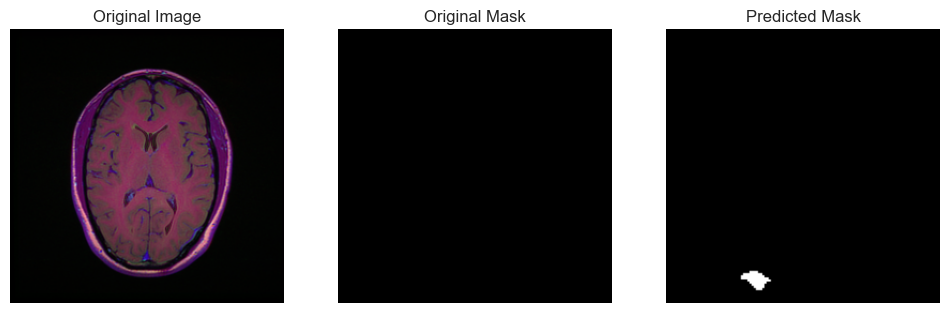

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


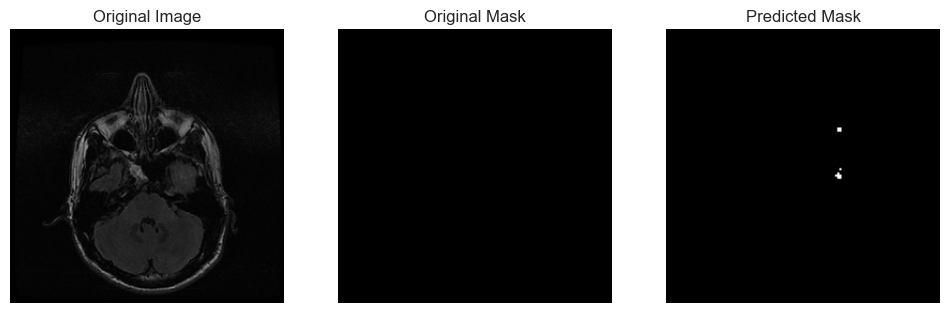

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


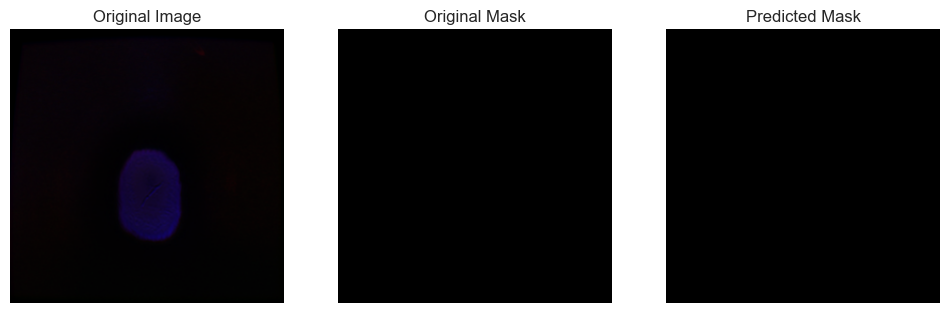

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


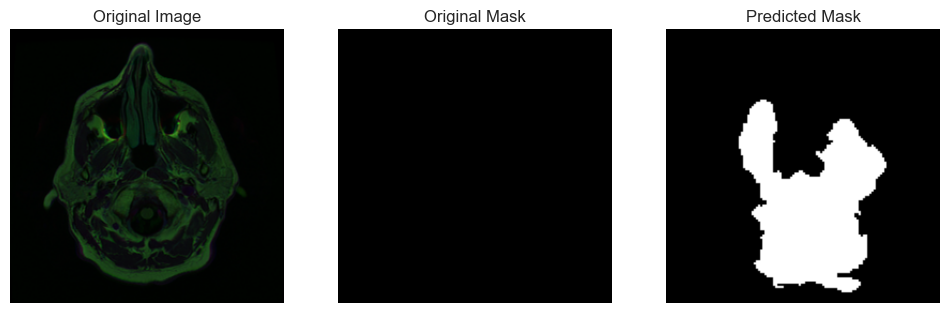

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


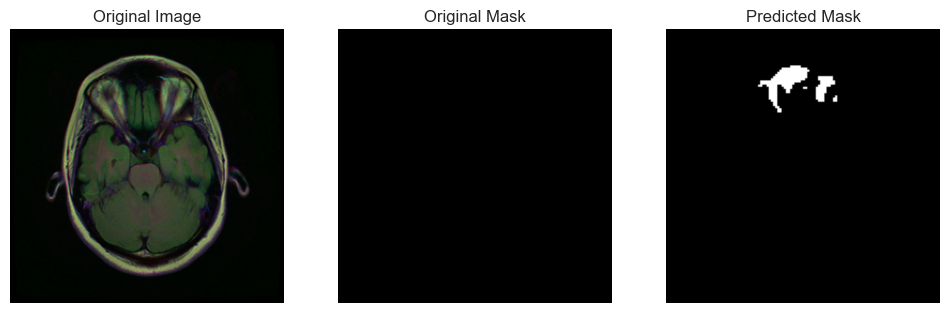

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


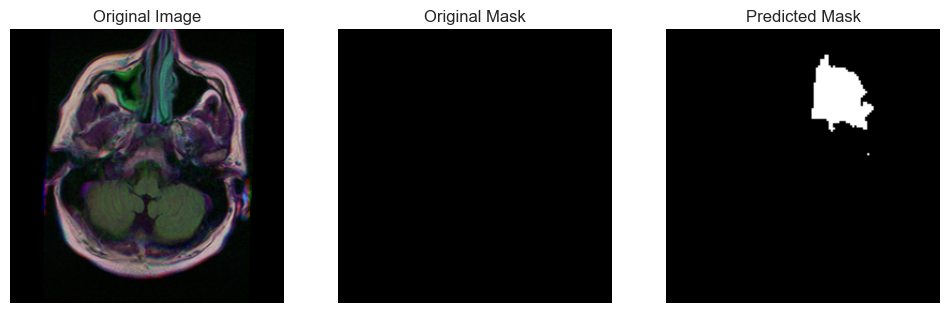

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


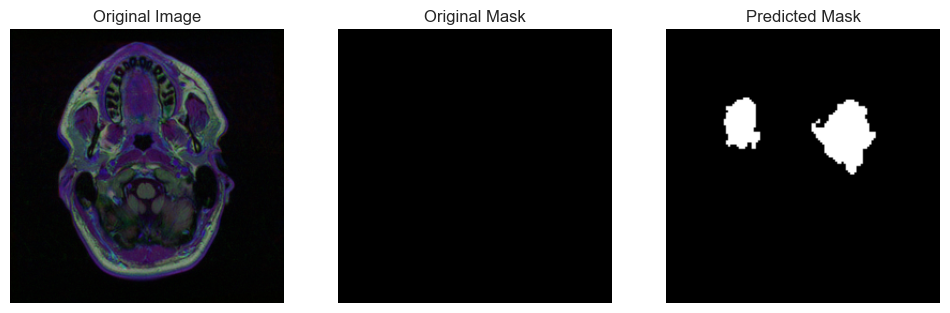

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


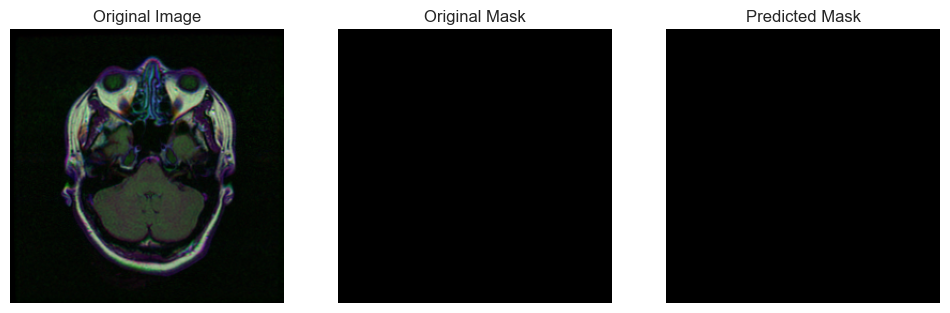

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


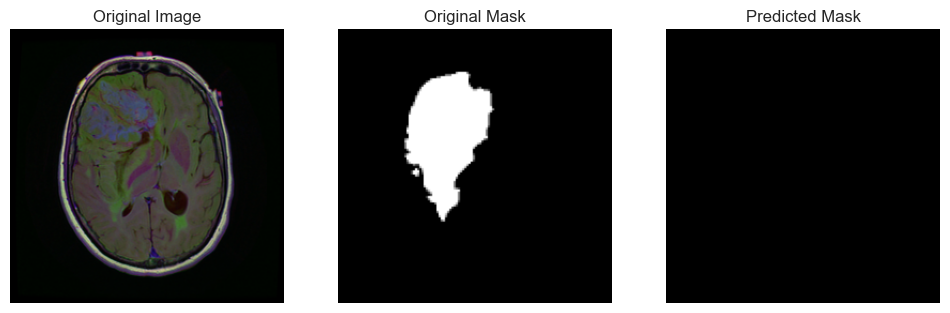

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


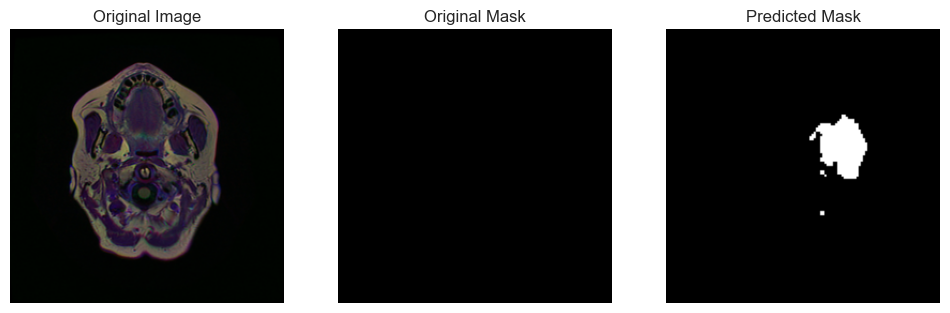

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


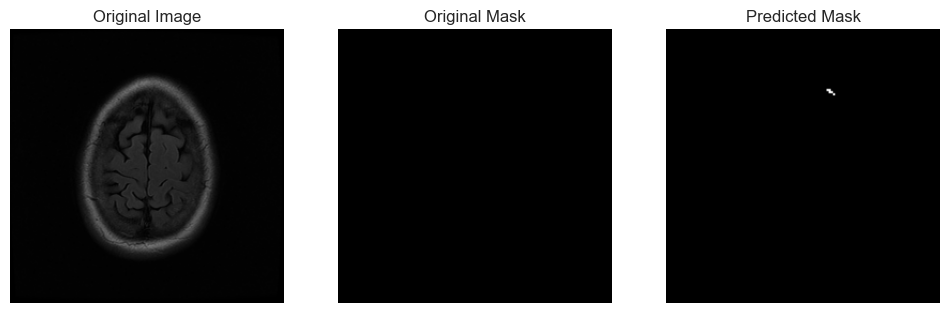

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


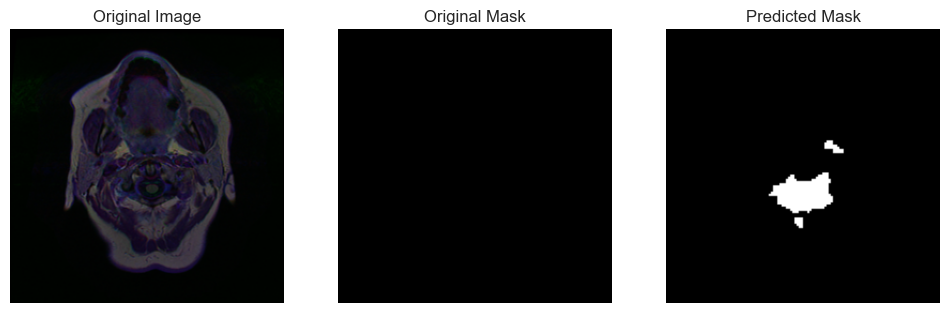

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

for _ in range(20):  # show 5 random examples
    index = np.random.randint(0, len(test_df))

    # Load image
    img_path = test_df['images_paths'].iloc[index]
    mask_path = test_df['masks_paths'].iloc[index]

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # keep colors correct
    img_resized = cv2.resize(img, (128, 128))   # match model input
    img_input = img_resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    # Prediction
    predicted_img = model.predict(img_input)[0]
    predicted_mask = (predicted_img > 0.5).astype(np.uint8)

    # Load true mask
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = cv2.resize(true_mask, (128, 128))

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="gray")
    plt.axis("off")
    plt.title("Original Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Predicted Mask")

    plt.show()


In [34]:
model.save("mobileunet_segmentation.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


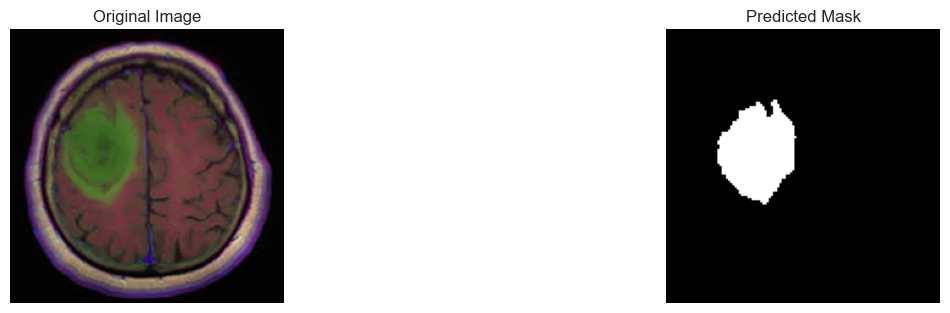

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your saved model
model = load_model("mobileunet_segmentation.h5",
                   custom_objects={"iou_metric": iou_metric, "dice_metric": dice_coef})

def predict_single_image(image_path, mask_path=None, img_size=(128, 128)):
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, img_size)
    img_norm = img_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    # Predict mask
    pred = model.predict(img_input)[0]
    pred_mask = (pred > 0.5).astype(np.uint8)

    # Plot
    plt.figure(figsize=(12, 12))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    # Original mask if available
    if mask_path:
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, img_size)
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_mask), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Example usage (from test_df)
image_path = r"C:\Users\Dell\Downloads\seg.jpeg"

# Call function without mask (since no ground truth available)
predict_single_image(image_path, mask_path=None)